In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
#from scipy.optimize import curve_fit
#import mdtraj as md
import os

In [2]:
def dir_to_trajs(directory):
    """
    loads atom positions from all LAMMPS files in given directory
    
    input directory: path of directory e.g. run3-100_dumplin (string)
    output: positions of all atoms at different times (numpy array) 
    """
    a = []
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file: 
        if os.path.isfile(f):
            a.append(np.loadtxt(f, skiprows=9, usecols=(1,2,3)))
    return np.asarray(a[-round(len(a)/2):])

In [3]:
def calcMSDs(directory,delta=1,samplesize=100):
    trajs = dir_to_trajs(directory)
    MSDs = []
    errs = []
    for gendist in range(1,trajs.shape[1],delta):
        a = []
        try:
            refatoms = np.random.choice(range(trajs.shape[1]-gendist), size=samplesize, replace=False)
        except:
            refatoms = range(trajs.shape[1]-gendist)
        for atom1 in refatoms:
            temp = trajs[:,atom1]-trajs[:,atom1+gendist]
            a.append(np.linalg.norm(temp, axis=1)**2)
        allSDs = np.asarray(a)
        MSD, err = np.mean(allSDs), np.std(allSDs, ddof=1) / np.sqrt(np.size(allSDs))
        MSDs.append(MSD)
        errs.append(err)
    return np.asarray(MSDs), np.asarray(errs)

In [12]:
def plotMSDs(directory,delta=1,samplesize=100):
    MSDs, errs = calcMSDs(directory,delta,samplesize)
    
    gendists = delta*np.arange(1, len(MSDs)+1)
    
    plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a function of genomic distance')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    plt.errorbar(gendists, MSDs, yerr=errs, fmt=',', linestyle='None') # pixel marker and no line
    plt.grid()
    plt.tight_layout()
    #plt.savefig('../plots/'+'MSDvsgendist_'+directory.split('/')[-1]+'_delta'+str(delta)+'_ssize'+str(samplesize)+'.pdf', format='pdf')
    plt.show()

In [47]:
def plotMSDs_avgruns(directory,delta=1,samplesize=100):
    allMSDs = []
    for filename in os.listdir(directory):
        # checking if it is a directory:
        f = os.path.join(directory, filename)
        if os.path.isdir(f):
            for file in os.listdir(f):
                dumplin = os.path.join(f, file)
                if os.path.isdir(dumplin):
                    allMSDs.append(calcMSDs(dumplin,delta,samplesize)[0])
            
    avgMSDs = np.mean(np.asarray(allMSDs), axis=0)
    errs = np.std(np.asarray(allMSDs), axis=0) / np.sqrt(len(allMSDs))
    gendists = delta*np.arange(1, len(avgMSDs)+1)
    
    plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a fct of gendist averaged over '+str(len(allMSDs))+' runs')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None') # , pixel marker or . point marker and no line
    plt.grid()
    plt.tight_layout()
    plt.savefig('../plots/'+'avgMSDvsgendist_'+directory.split('/')[-1]+'_delta'+str(delta)+'_ssize'+str(samplesize)+'.pdf', format='pdf')
    plt.show()

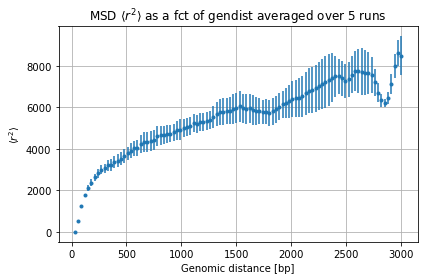

Wall time: 1min 8s


In [50]:
%%time
directory = '../simdata/runs3000'
delta = 30 # difference in gendist between adjacent data points in the plot
samplesize = 1000 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
plotMSDs_avgruns(directory,delta,samplesize)